In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
# import polars as pl
import matplotlib.pyplot as plt

# paths
from pathlib import Path
work = Path.home() / "Work"
lvk = work / "LVK_Temperature_Analysis"
data = lvk / "data"

Load 20 years of temperature data from the Livermore Airport.  Convert to Fahrenheit as necessary.

In [3]:
dfs = {}

# 2024 almost thru October 31.  This data is in Fahrenheit.
df = pd.read_csv(data / "3829432.csv.zip", compression='zip')

df['DATE'] = pd.to_datetime(df['DATE'])

# Filter out NaN values and convert temperature to numeric
df_clean = df.dropna(subset=['HourlyDryBulbTemperature'])
df_clean['HourlyDryBulbTemperature'] = pd.to_numeric(df_clean['HourlyDryBulbTemperature'], errors='coerce')
df_clean = df_clean.dropna(subset=['HourlyDryBulbTemperature'])  # Remove any values that couldn't be converted

dfs["2024"] = df_clean

for year in ["2023", "2022", "2021", "2020", "2019", "2018", "2017", "2016", "2015", "2014", "2013", "2012", "2011", "2010", "2009", "2008", "2007", "2006", "2005", "2004"]:
    
    df = pd.read_csv(data / f"LCD_USW00023285_{year}.csv.zip", compression='zip')
    df['DATE'] = pd.to_datetime(df['DATE'])
    
    # Filter out NaN values and convert temperature to numeric
    df_clean = df.dropna(subset=['HourlyDryBulbTemperature'])
    df_clean['HourlyDryBulbTemperature'] = pd.to_numeric(df_clean['HourlyDryBulbTemperature'], errors='coerce')
    df_clean = df_clean.dropna(subset=['HourlyDryBulbTemperature'])
    
    # Convert C to F: (C * 9/5) + 32
    df_clean['HourlyDryBulbTemperature'] = (df_clean['HourlyDryBulbTemperature'] * 9/5) + 32

    dfs[year] = df_clean

/var/folders/jz/23vnqjfn1xg6v4l3v0tttrmc0000gp/T/ipykernel_31571/2050865652.py:4: DtypeWarning: Columns (3,38,44,73,89,96,97,98,99,100,101,102,103,104,105,106,107,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data / "3829432.csv.zip", compression='zip')
/var/folders/jz/23vnqjfn1xg6v4l3v0tttrmc0000gp/T/ipykernel_31571/2050865652.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['HourlyDryBulbTemperature'] = pd.to_numeric(df_clean['HourlyDryBulbTemperature'], errors='coerce')
/var/folders/jz/23vnqjfn1xg6v4l3v0tttrmc0000gp/T/ipykernel_31571/2050865652.py:17: DtypeWarning: Columns (60,77) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data / 

Raw data temperatures at 9 PM.


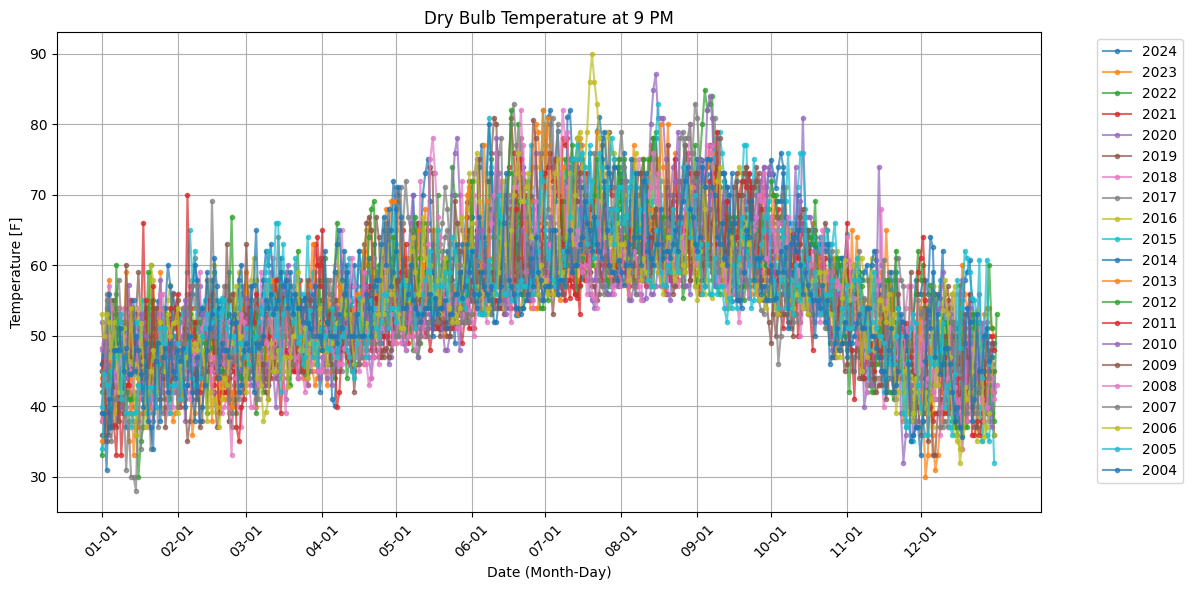

In [4]:
plt.figure(figsize=(12, 6))

# Plot each year from the dfs dictionary
for year, df in dfs.items():    
    # Filter for 9 PM readings and create month-day format
    df_9pm = df[df['DATE'].dt.hour == 21]
    df_9pm = df_9pm.groupby(df_9pm['DATE'].dt.date).first()  # Group by date to get one reading per day
    
    plt.plot(df_9pm['HourlyDryBulbTemperature'].tolist(),
             'o-', 
             label=str(year),
             alpha=0.7,  # Add some transparency for overlapping points
             markersize=3)  # Smaller markers to reduce crowding

# Set x-axis ticks to show only first day of each month
# Assuming 365 days in a year, calculate positions for first of each month
month_positions = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]  # Positions of 1st of each month
month_labels = [f"{m:02d}-01" for m in range(1, 13)]
plt.xticks(month_positions, month_labels, rotation=45)

plt.title('Dry Bulb Temperature at 9 PM')
plt.xlabel('Date (Month-Day)')
plt.ylabel('Temperature [F]')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
plt.tight_layout()
plt.show()

The same raw datawith plotly express.


In [5]:
import plotly.express as px

# Create a list to store all the data
plot_data = []

# Process each year's data
for year, df in dfs.items():
    # Filter for 9 PM readings
    df_9pm = df[df['DATE'].dt.hour == 21]
    df_9pm = df_9pm.groupby(df_9pm['DATE'].dt.date).first()
    df_9pm['month_day'] = pd.to_datetime(df_9pm.index).strftime('%m-%d')
    df_9pm['Year'] = year  # Add year for coloring
    
    plot_data.append(df_9pm)

# Combine all years' data
all_data = pd.concat(plot_data)

# Create the plot
fig = px.line(all_data, 
              x='month_day',
              y='HourlyDryBulbTemperature',
              color='Year',
              markers=True,
              title='Dry Bulb Temperature at 9 PM')

# Update layout
fig.update_layout(
    xaxis_title='Date (Month-Day)',
    yaxis_title='Temperature [F]',
    xaxis=dict(
        tickmode='array',
        ticktext=[f"{m:02d}-01" for m in range(1, 13)],
        tickvals=[f"{m:02d}-01" for m in range(1, 13)],
        tickangle=45
    ),
    width=1000,
    height=600
)

# Create list to store all data from 2004-2020
all_temps = []

# Process each year's data
for year in range(2004, 2025):  # up to 2024
    year_str = str(year)
    if year_str in dfs:
        df = dfs[year_str]
        
        # Filter for 9 PM readings
        df_9pm = df[df['DATE'].dt.hour == 21]
        df_9pm = df_9pm.groupby(df_9pm['DATE'].dt.date).first()
        df_9pm['month_day'] = pd.to_datetime(df_9pm.index).strftime('%m-%d')
        
        # Add to list
        all_temps.append(df_9pm[['month_day', 'HourlyDryBulbTemperature']])

# Combine all years
combined_df = pd.concat(all_temps)

# Calculate statistics by month-day
stats_df = combined_df.groupby('month_day').agg({
    'HourlyDryBulbTemperature': ['mean', 'std', 'count']
}).reset_index()

# Flatten column names
stats_df.columns = ['month_day', 'mean_temp', 'std_temp', 'count']

# Sort by month and day
stats_df['sort_date'] = pd.to_datetime('2000-' + stats_df['month_day'])
stats_df = stats_df.sort_values('sort_date')

# Plot the results
fig = px.line(stats_df, 
              x='month_day',
              y=['mean_temp', 'std_temp'],
              title='Daily Temperature Statistics (2004-2020)',
              labels={'value': 'Temperature [F]', 'month_day': 'Date (Month-Day)'},
              color_discrete_map={'mean_temp': 'blue', 'std_temp': 'red'})

fig.update_layout(
    xaxis=dict(
        tickmode='array',
        ticktext=[f"{m:02d}-01" for m in range(1, 13)],
        tickvals=[f"{m:02d}-01" for m in range(1, 13)],
        tickangle=45
    ),
    width=1000,
    height=600,
    showlegend=True
)

# Display first few rows of statistics
print("\nFirst few rows of statistics:")
display(stats_df.head(10))


Calculate the rolling mean and standard deviation of the temperature at 9 PMwith a 5-day window.

In [6]:
# Set the window size (N)
N = 5
half_window = N // 2  # Integer division to get window on each side

# Create list to store all data from 2004-2020
all_temps = []

# Process each year's data
for year in range(2004, 2025):  # up to 2024
    year_str = str(year)
    if year_str in dfs:
        df = dfs[year_str]
        
        # Filter for 9 PM readings
        df_9pm = df[df['DATE'].dt.hour == 21]
        df_9pm = df_9pm.groupby(df_9pm['DATE'].dt.date).first()
        df_9pm['month_day'] = pd.to_datetime(df_9pm.index).strftime('%m-%d')
        
        # Add to list
        all_temps.append(df_9pm[['month_day', 'HourlyDryBulbTemperature']])

# Combine all years
combined_df = pd.concat(all_temps)

# Calculate statistics by month-day
stats_df = combined_df.groupby('month_day').agg({
    'HourlyDryBulbTemperature': ['mean', 'std', 'count']
}).reset_index()

# Flatten column names
stats_df.columns = ['month_day', 'mean_temp', 'std_temp', 'count']

# Sort by month and day
stats_df['sort_date'] = pd.to_datetime('2000-' + stats_df['month_day'])
stats_df = stats_df.sort_values('sort_date')

# Calculate rolling statistics
# For each day, include N days centered on that day across all years
rolling_stats = []
month_days = stats_df['month_day'].tolist()

for i in range(len(month_days)):
    # Get the indices for the window, handling wrap-around at year boundaries
    window_indices = [(i + j) % len(month_days) for j in range(-half_window, half_window + 1)]
    window_days = [month_days[j] for j in window_indices]
    
    # Get all temperatures for these month-days across all years
    window_temps = combined_df[combined_df['month_day'].isin(window_days)]['HourlyDryBulbTemperature']
    
    rolling_stats.append({
        'month_day': month_days[i],
        'rolling_mean': window_temps.mean(),
        'rolling_std': window_temps.std()
    })

rolling_stats_df = pd.DataFrame(rolling_stats)
stats_df = stats_df.merge(rolling_stats_df, on='month_day')

# Display first few rows of statistics
print("\nFirst few rows of rolling statistics:")
display(stats_df[['month_day', 'mean_temp', 'rolling_mean', 'std_temp', 'rolling_std']].head(10))


First few rows of rolling statistics:


,month_day,mean_temp,rolling_mean,std_temp,rolling_std
0,01-01,42.343810,44.400388,5.663591,5.850068
1,01-02,43.892381,44.259038,4.782378,5.855151
2,01-03,45.179048,44.271810,6.638477,5.799032
3,01-04,45.647619,44.827810,6.551307,5.554723
4,01-05,44.296190,45.351238,5.101630,5.900085
5,01-06,45.123810,45.663048,4.734578,5.673052
6,01-07,46.509524,45.435619,6.544477,5.395389
7,01-08,46.738095,45.831238,5.378524,5.220670
8,01-09,44.510476,45.950667,5.080888,5.600838
9,01-10,46.274286,45.841714,4.222308,5.321997


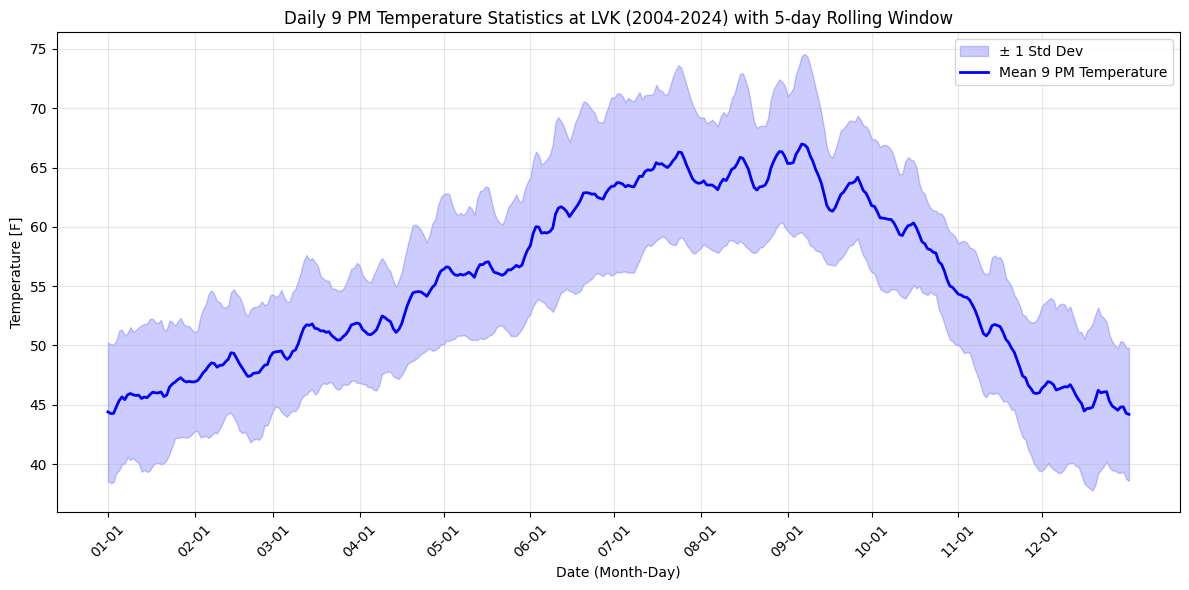

In [7]:
plt.figure(figsize=(12, 6))

# Get x values (just indices since month_day strings don't plot well)
x = range(len(stats_df))

# Plot filled region for standard deviation
plt.fill_between(x, 
                 stats_df['rolling_mean'] - stats_df['rolling_std'],
                 stats_df['rolling_mean'] + stats_df['rolling_std'],
                 alpha=0.2,
                 color='blue',
                 label='± 1 Std Dev')

# Plot mean line
plt.plot(x, stats_df['rolling_mean'], 
         color='blue', 
         linewidth=2,
         label='Mean 9 PM Temperature')

# Set x-axis ticks to show months
month_positions = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]
month_labels = [f"{m:02d}-01" for m in range(1, 13)]
plt.xticks(month_positions, month_labels, rotation=45)

plt.title(f'Daily 9 PM Temperature Statistics at LVK (2004-2024) with {N}-day Rolling Window')
plt.xlabel('Date (Month-Day)')
plt.ylabel('Temperature [F]')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Here is a function to plot the temperature data vs the historical data for any number of years.

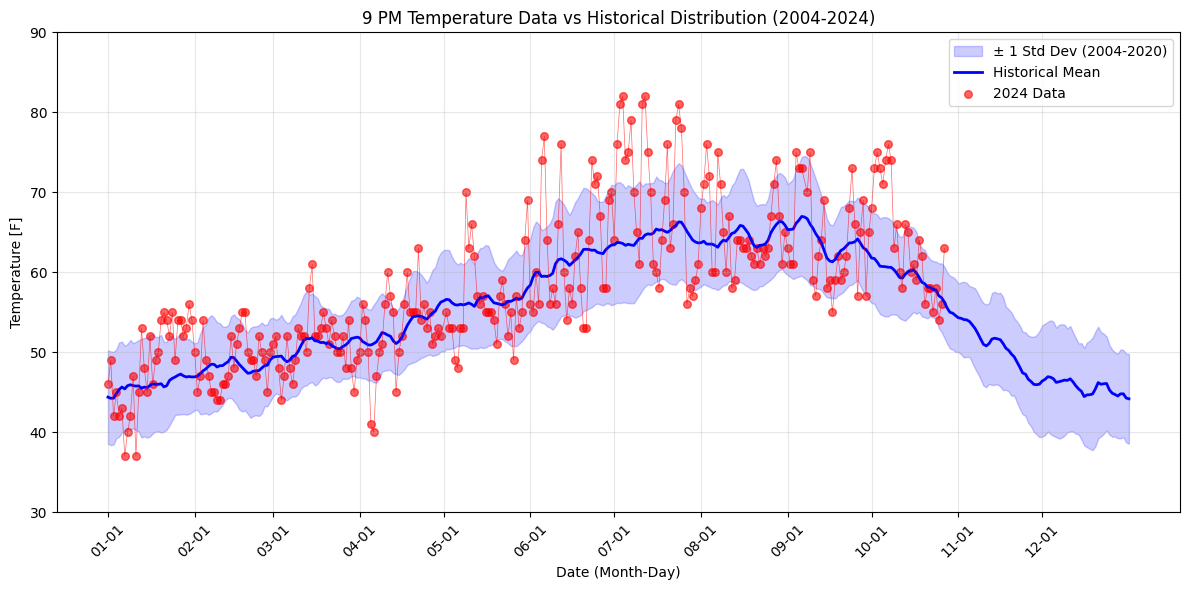

In [8]:
def plot_years_vs_historical(years_to_plot, dfs, stats_df, colors=None):
    """
    Plot temperature data for specified years against historical baseline.
    
    Args:
        years_to_plot (list): List of years as strings (e.g. ["2021", "2024"])
        dfs (dict): Dictionary containing DataFrames for each year
        stats_df (DataFrame): DataFrame containing historical statistics
        colors (list, optional): List of colors for each year. If None, will use default color cycle
    """
    plt.figure(figsize=(12, 6))

    # Plot baseline statistics
    x = range(len(stats_df))
    plt.fill_between(x, 
                     stats_df['rolling_mean'] - stats_df['rolling_std'],
                     stats_df['rolling_mean'] + stats_df['rolling_std'],
                     alpha=0.2,
                     color='blue',
                     label='± 1 Std Dev (2004-2020)')

    plt.plot(x, stats_df['rolling_mean'], 
             color='blue', 
             linewidth=2,
             label='Historical Mean')

    # Create month-day to index mapping
    month_day_to_idx = {md: idx for idx, md in enumerate(stats_df['month_day'])}

    # Plot each requested year
    if colors is None:
        colors = plt.cm.Set2(np.linspace(0, 1, len(years_to_plot)))

    for year, color in zip(years_to_plot, colors):
        if year in dfs:
            # Process year's data
            df_year = dfs[year]
            df_year_9pm = df_year[df_year['DATE'].dt.hour == 21]
            df_year_9pm = df_year_9pm.groupby(df_year_9pm['DATE'].dt.date).first()
            df_year_9pm['month_day'] = pd.to_datetime(df_year_9pm.index).strftime('%m-%d')

            # Map to x-axis positions
            x_year = [month_day_to_idx[md] for md in df_year_9pm['month_day']]

            # Plot line and scatter
            plt.plot(x_year, 
                    df_year_9pm['HourlyDryBulbTemperature'],
                    color=color,
                    linewidth=0.5,
                    alpha=0.6)
            plt.scatter(x_year, 
                       df_year_9pm['HourlyDryBulbTemperature'],
                       color=color,
                       alpha=0.6,
                       label=f'{year} Data',
                       s=30)

    # Set x-axis ticks to show months
    month_positions = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]
    month_labels = [f"{m:02d}-01" for m in range(1, 13)]
    plt.xticks(month_positions, month_labels, rotation=45)

    plt.title('9 PM Temperature Data vs Historical Distribution (2004-2024)')
    plt.xlabel('Date (Month-Day)')
    plt.ylabel('Temperature [F]')
    plt.ylim(30, 90)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
plot_years_vs_historical(["2024"], dfs, stats_df, colors=["red"])

Compare the recent temperature (at 9 PM) histories to those of the 2004-2006 period at the beginning of the dataset.  The recent data shows substantially more warm outlier days compared to the earlier period, which is nicely constistent with the standard deviation.  (The mean and standard deviation are calculated from ALL years.)  

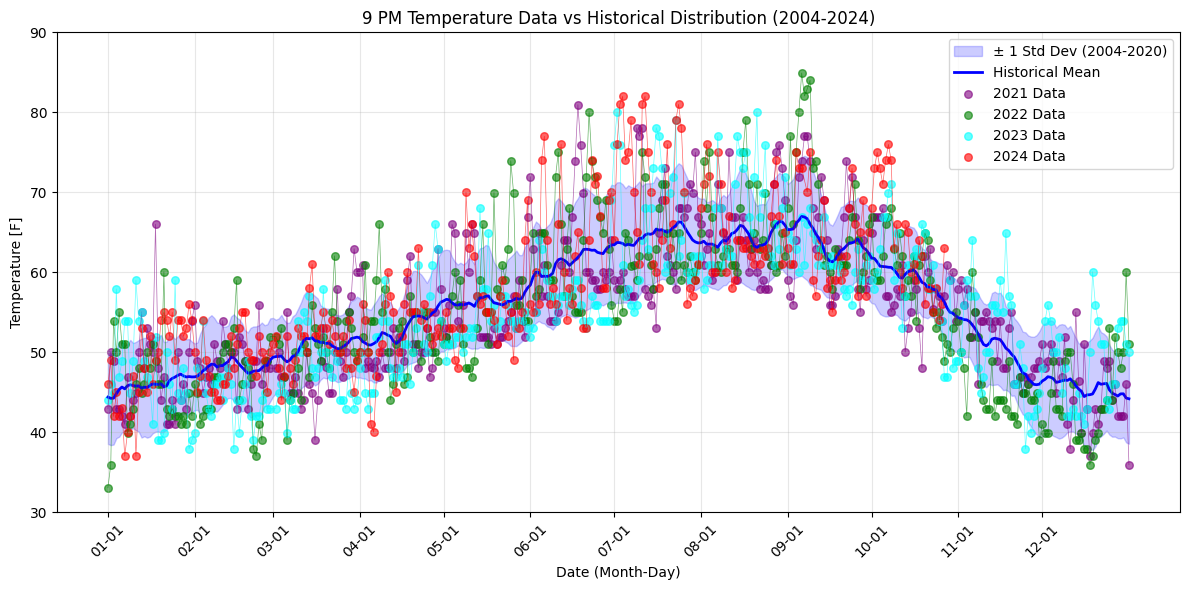

In [9]:
plot_years_vs_historical(["2021", "2022", "2023", "2024"], dfs, stats_df, colors=["purple", "green", "cyan", "red"])


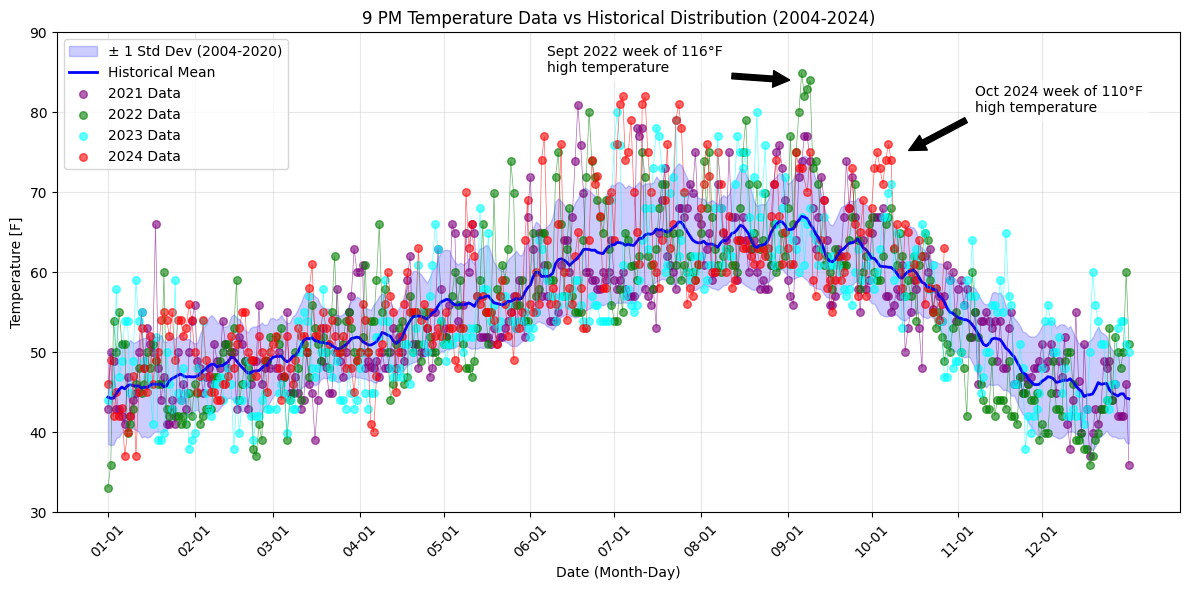

In [10]:
# Custom figure with arrow annotations:
years_to_plot = ["2021", "2022", "2023", "2024"]
colors=["purple", "green", "cyan", "red"]

plt.figure(figsize=(12, 6))

# Plot baseline statistics
x = range(len(stats_df))
plt.fill_between(x, 
                    stats_df['rolling_mean'] - stats_df['rolling_std'],
                    stats_df['rolling_mean'] + stats_df['rolling_std'],
                    alpha=0.2,
                    color='blue',
                    label='± 1 Std Dev (2004-2020)')

plt.plot(x, stats_df['rolling_mean'], 
            color='blue', 
            linewidth=2,
            label='Historical Mean')

# Create month-day to index mapping
month_day_to_idx = {md: idx for idx, md in enumerate(stats_df['month_day'])}

# Plot each requested year
if colors is None:
    colors = plt.cm.Set2(np.linspace(0, 1, len(years_to_plot)))

for year, color in zip(years_to_plot, colors):
    if year in dfs:
        # Process year's data
        df_year = dfs[year]
        df_year_9pm = df_year[df_year['DATE'].dt.hour == 21]
        df_year_9pm = df_year_9pm.groupby(df_year_9pm['DATE'].dt.date).first()
        df_year_9pm['month_day'] = pd.to_datetime(df_year_9pm.index).strftime('%m-%d')

        # Map to x-axis positions
        x_year = [month_day_to_idx[md] for md in df_year_9pm['month_day']]

        # Plot line and scatter
        plt.plot(x_year, 
                df_year_9pm['HourlyDryBulbTemperature'],
                color=color,
                linewidth=0.5,
                alpha=0.6)
        plt.scatter(x_year, 
                    df_year_9pm['HourlyDryBulbTemperature'],
                    color=color,
                    alpha=0.6,
                    label=f'{year} Data',
                    s=30)

# Set x-axis ticks to show months
month_positions = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]
month_labels = [f"{m:02d}-01" for m in range(1, 13)]
plt.xticks(month_positions, month_labels, rotation=45)

# Add annotation with arrow
plt.annotate('Sept 2022 week of 116°F\nhigh temperature', 
            xy=(245, 84),  # Position of arrow head (x=Sept 1st, y=85)
            xytext=(157, 85),  # Position of text
            arrowprops=dict(facecolor='black', shrink=0.05),
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

plt.annotate('Oct 2024 week of 110°F\nhigh temperature', 
            xy=(285, 75),  # Position of arrow head (x=Sept 1st, y=85)
            xytext=(310, 80),  # Position of text
            arrowprops=dict(facecolor='black', shrink=0.05),
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

plt.title('9 PM Temperature Data vs Historical Distribution (2004-2024)')
plt.xlabel('Date (Month-Day)')
plt.ylabel('Temperature [F]')
plt.ylim(30, 90)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


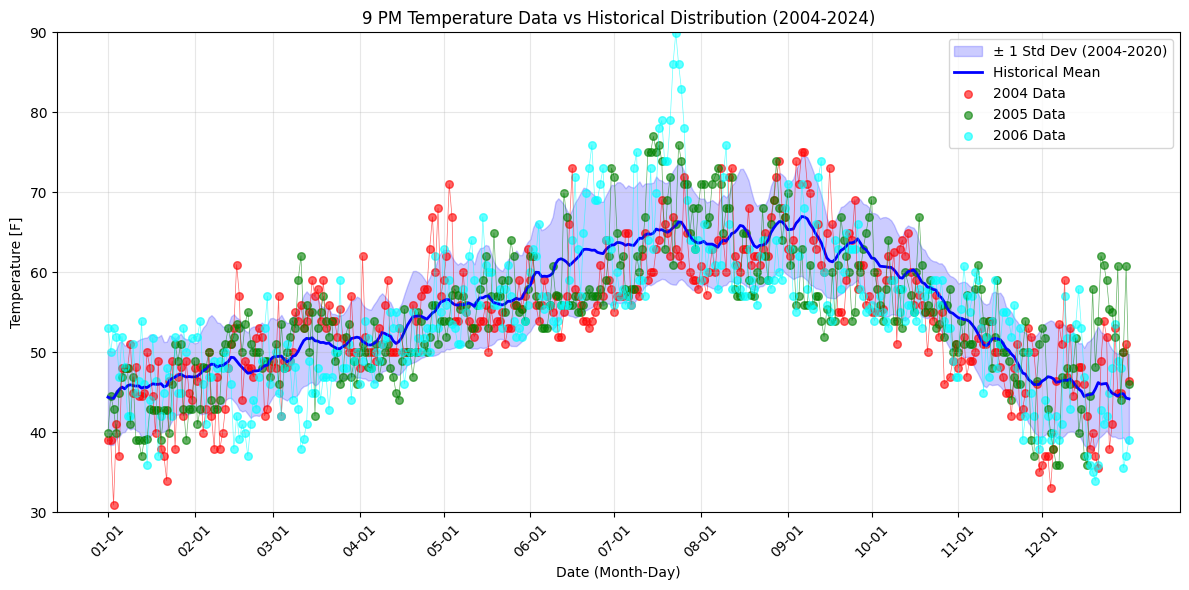

In [11]:
plot_years_vs_historical(["2004", "2005", "2006"], dfs, stats_df, colors=["red", "green", "cyan", "magenta"])

---
Now let's tally the number of extreme days per year, i.e. days when the temperature exceeded the historical mean by at least 10°F.

In [12]:
def find_extreme_days(year, dfs, stats_df, dtemp):
    """
    Find days when temperature exceeded historical mean by at least dtemp degrees.
    
    Args:
        year (str): Year to analyze (e.g. "2024")
        dfs (dict): Dictionary containing DataFrames for each year
        stats_df (DataFrame): DataFrame containing historical statistics
        dtemp (float): Minimum temperature difference to report
        
    Returns:
        DataFrame: Days where temperature exceeded mean by dtemp, sorted by exceedance
    """
    if year not in dfs:
        return None
    
    # Get data for specified year
    df_year = dfs[year]
    df_year_9pm = df_year[df_year['DATE'].dt.hour == 21]
    
    # Create a copy to avoid modifying the original
    df_9pm_grouped = df_year_9pm.copy()
    df_9pm_grouped = df_9pm_grouped.groupby(df_9pm_grouped['DATE'].dt.date).first()
    df_9pm_grouped['month_day'] = df_9pm_grouped['DATE'].dt.strftime('%m-%d')
    
    # Merge with historical stats
    df_merged = df_9pm_grouped.merge(stats_df[['month_day', 'rolling_mean']], 
                                   on='month_day', 
                                   how='left')
    
    # Calculate temperature difference
    df_merged['temp_diff'] = df_merged['HourlyDryBulbTemperature'] - df_merged['rolling_mean']
    
    # Find days exceeding threshold
    extreme_days = df_merged[df_merged['temp_diff'] >= dtemp].copy()
    
    # Sort by temperature difference
    extreme_days = extreme_days.sort_values('temp_diff', ascending=False)
    
    # Format date using the DATE column that's already datetime
    extreme_days['date'] = extreme_days['DATE'].dt.strftime('%Y-%m-%d')
    
    return extreme_days[['date', 'month_day', 'HourlyDryBulbTemperature', 
                        'rolling_mean', 'temp_diff']]

# Example usage:
extreme_days = find_extreme_days("2024", dfs, stats_df, dtemp=10)
if extreme_days is not None and not extreme_days.empty:
    print(f"\nDays in 2024 when temperature exceeded historical mean by ≥10°F:")
    print(extreme_days.to_string(float_format=lambda x: f"{x:.1f}"))
else:
    print("No days found exceeding threshold")


Days in 2024 when temperature exceeded historical mean by ≥10°F:
           date month_day  HourlyDryBulbTemperature  rolling_mean  temp_diff
183  2024-07-03     07-03                      82.0          63.6       18.4
155  2024-06-05     06-05                      77.0          59.5       17.5
191  2024-07-11     07-11                      82.0          64.7       17.3
182  2024-07-02     07-02                      81.0          63.7       17.3
190  2024-07-10     07-10                      81.0          64.2       16.8
186  2024-07-06     07-06                      79.0          63.4       15.6
277  2024-10-06     10-06                      76.0          60.6       15.4
203  2024-07-23     07-23                      81.0          66.3       14.7
154  2024-06-04     06-04                      74.0          59.5       14.5
161  2024-06-11     06-11                      76.0          61.7       14.3
127  2024-05-08     05-08                      70.0          56.0       14.0
273  2024-

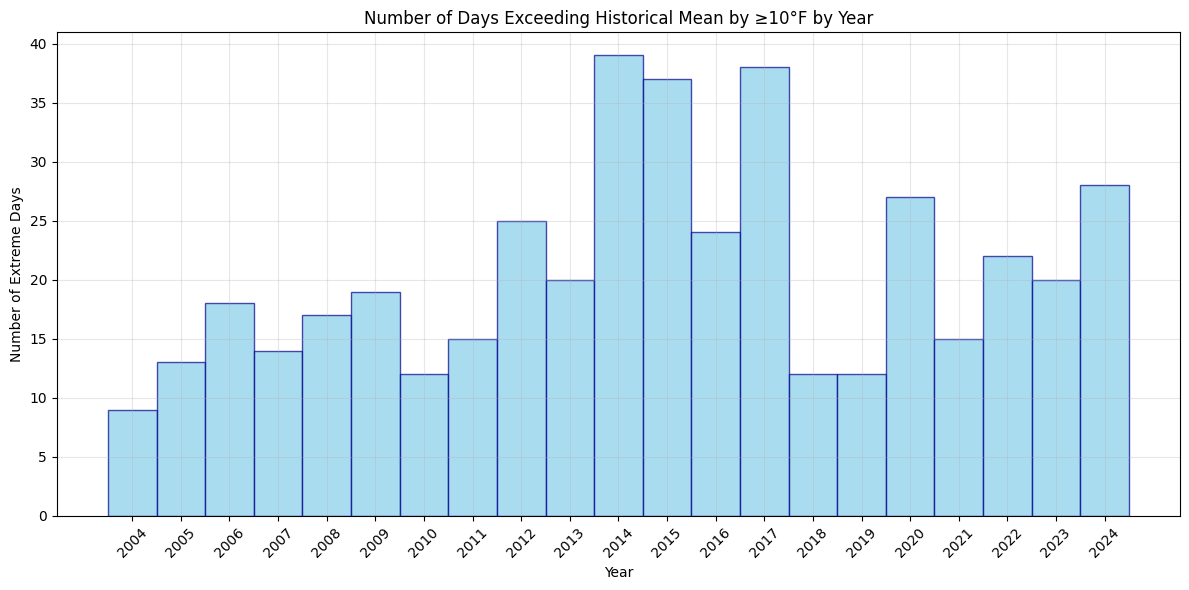

In [13]:
# Get sorted list of years
sorted_years = sorted(dfs.keys())

# Create a dictionary of year: number of extreme days
extreme_days_by_year = {yr: len(find_extreme_days(yr, dfs, stats_df, dtemp=10)) for yr in sorted_years}

# Create the plot
plt.figure(figsize=(12,6))
plt.bar(extreme_days_by_year.keys(), extreme_days_by_year.values(), width = 1.0, color='skyblue', alpha=0.7, edgecolor='darkblue', linewidth=1)
plt.title('Number of Days Exceeding Historical Mean by ≥10°F by Year')
plt.xlabel('Year')
plt.ylabel('Number of Extreme Days')
plt.grid(True, alpha=0.3)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


It is interesting that during the drought of 2012-2016, there were many exceedingly warm days (>35/year), so it is worth plotting those dates as well. 

It is important to note that 2024 is not over yet, so the actual number of extreme days in 2024 may be higher than the 28 reported here.

As shown below, these years also had many warm excursions, similar to recent years.

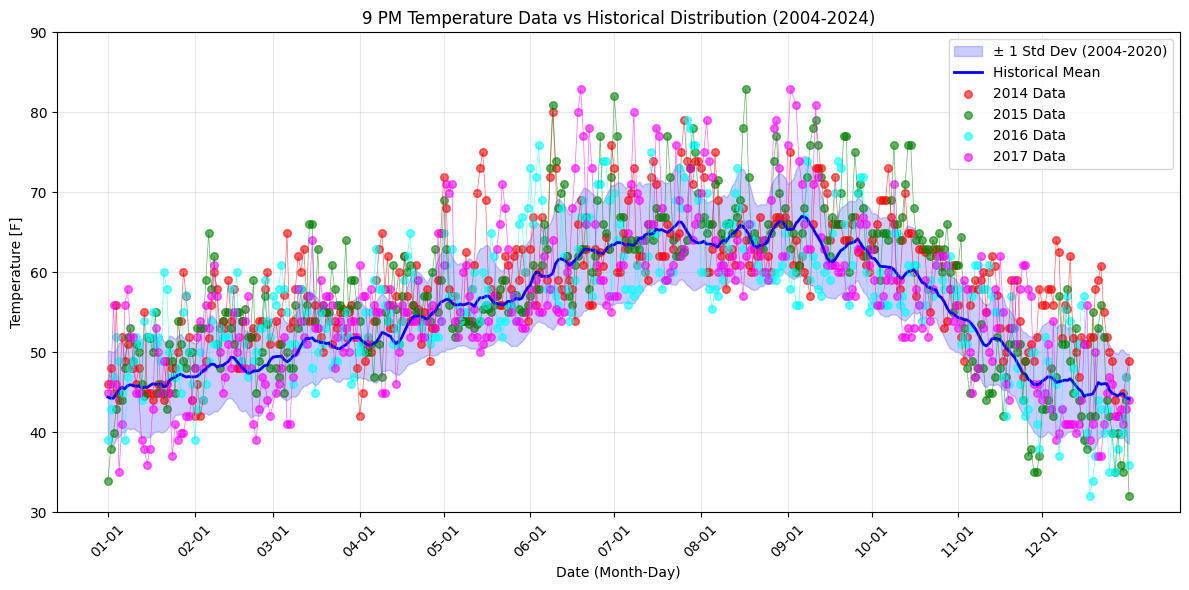

In [14]:
plot_years_vs_historical(["2014", "2015", "2016","2017"], dfs, stats_df, colors=["red", "green", "cyan", "magenta"])


---
Now load the ocean buoy data and compare the temperature excursions to those at the Livermore airport.

In [27]:
# Load the buoy exceedance data
buoy_df = pd.read_csv(data / "buoy_exceedance_data.csv")

buoy_df['date'] = pd.to_datetime(buoy_df['date'])

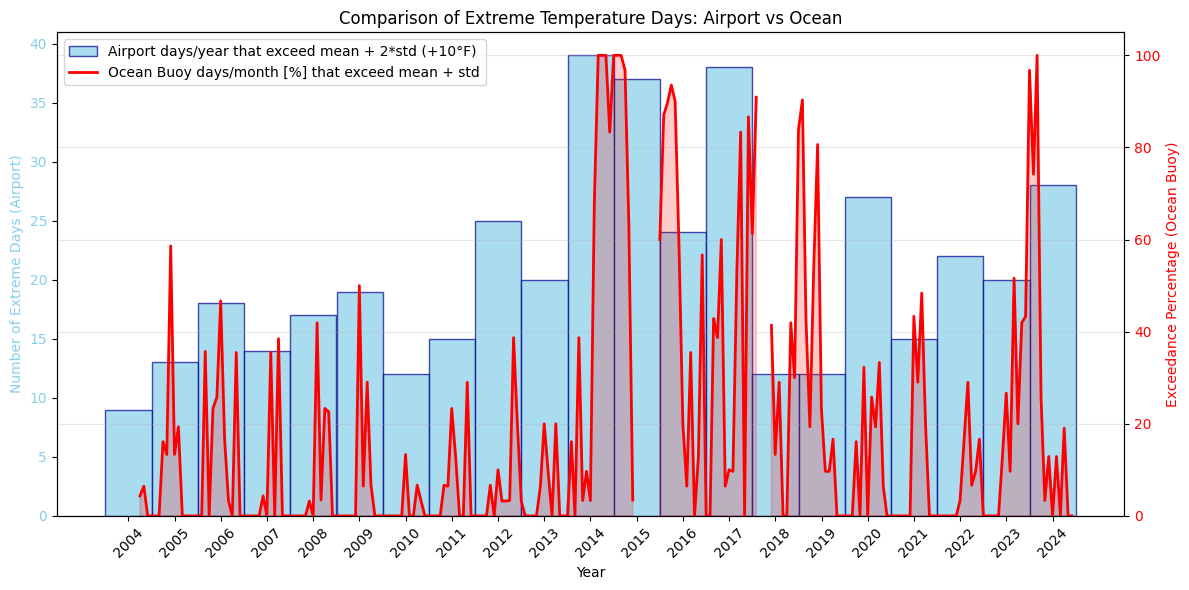

In [28]:
import matplotlib.dates as mdates

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()

# Plot airport data on first y-axis (blue bars)
years = list(map(int, extreme_days_by_year.keys()))
bar_positions = [pd.Timestamp(f"{year}-01-01") for year in years]
bar_width = pd.Timedelta(days=365)

# Plot bars with dark edges
bars = ax1.bar(bar_positions, extreme_days_by_year.values(), 
               width=bar_width,
               color='skyblue', alpha=0.7, 
               label='Airport days/year that exceed mean + 2*std (+10°F)',
               align='edge',
               edgecolor='darkblue',
               linewidth=1)

ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Extreme Days (Airport)', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Convert buoy dates to datetime for plotting at monthly resolution
buoy_dates = pd.to_datetime(buoy_df['date'])

# Plot filled area under the curve with high transparency
ax2.fill_between(buoy_dates, buoy_df['exceedance_percentage'], 
                 alpha=0.2, color='red')

# Plot the line on top of the fill
ax2.plot(buoy_dates, buoy_df['exceedance_percentage'], 
         color='red', linewidth=2, # marker='o', markersize=3,
         label='Ocean Buoy days/month [%] that exceed mean + std')

ax2.set_ylabel('Exceedance Percentage (Ocean Buoy)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legends for both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Comparison of Extreme Temperature Days: Airport vs Ocean')
plt.grid(True, alpha=0.3)

# Format x-axis to show years centered on bars
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
tick_positions = [pd.Timestamp(f"{year}-07-01") for year in years]
ax1.set_xticks(tick_positions)
#plt.xticks(rotation=45)
ax1.set_xticklabels(years, rotation=45)

# Ensure both y-axes start at 0
ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

---
Now let's break down the extreme air temperature days at the airport by quarter.

In [29]:
# Function to count extreme days by quarter
def count_extreme_days_by_quarter(year, dfs, stats_df, dtemp=10):
    extreme_days = find_extreme_days(year, dfs, stats_df, dtemp)
    if extreme_days is None or extreme_days.empty:
        return [0, 0, 0, 0]
    
    # Convert date strings to datetime
    extreme_days['date'] = pd.to_datetime(extreme_days['date'])
    
    # Get quarter for each date
    extreme_days['quarter'] = extreme_days['date'].dt.quarter
    
    # Count days per quarter
    quarter_counts = extreme_days.groupby('quarter').size()
    
    # Ensure all quarters are represented
    counts = [quarter_counts.get(q, 0) for q in range(1, 5)]
    return counts

# Get quarterly counts for all years
years = sorted(dfs.keys())
quarterly_data = []
quarters = ['Q1', 'Q2', 'Q3', 'Q4']

for year in years:
    counts = count_extreme_days_by_quarter(year, dfs, stats_df)
    for q, count in zip(quarters, counts):
        quarterly_data.append({
            'year': int(year),
            'quarter': q,
            'count': count
        })

# Convert to DataFrame
df_quarterly = pd.DataFrame(quarterly_data)

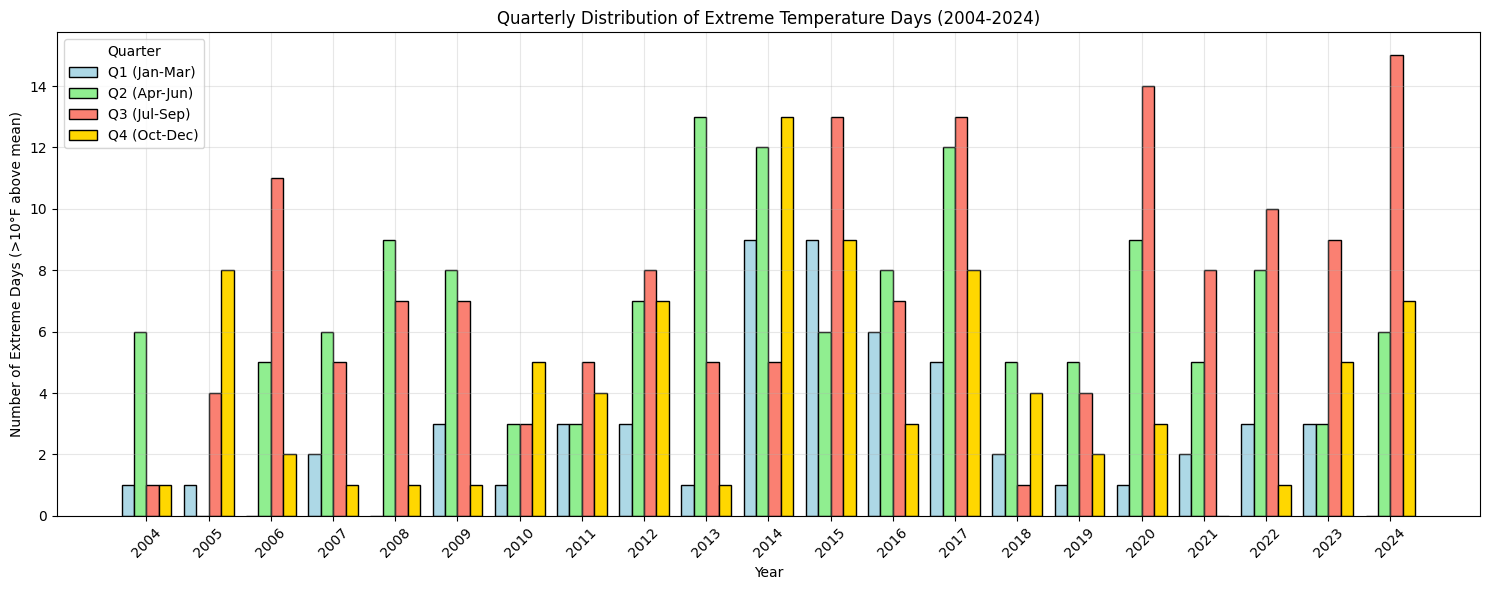

In [30]:
# Create the plot
plt.figure(figsize=(15, 6))

# Calculate bar positions
bar_width = 0.2
quarters = ['Q1', 'Q2', 'Q3', 'Q4']
quarter_labels = {'Q1': 'Jan-Mar', 'Q2': 'Apr-Jun', 'Q3': 'Jul-Sep', 'Q4': 'Oct-Dec'}
colors = ['lightblue', 'lightgreen', 'salmon', 'gold']

# Convert years to integers for plotting
year_ints = [int(year) for year in years]

for i, (quarter, color) in enumerate(zip(quarters, colors)):
    mask = df_quarterly['quarter'] == quarter
    plt.bar(df_quarterly[mask]['year'] + i*bar_width - 1.5*bar_width, 
            df_quarterly[mask]['count'],
            width=bar_width,
            label=f'{quarter} ({quarter_labels[quarter]})',
            color=color,
            edgecolor='black',
            linewidth=1)

plt.xlabel('Year')
plt.ylabel('Number of Extreme Days (>10°F above mean)')
plt.title('Quarterly Distribution of Extreme Temperature Days (2004-2024)')
plt.legend(title='Quarter', loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(year_ints, year_ints, rotation=45)  # Using integer years for both positions and labels

plt.tight_layout()
plt.show()

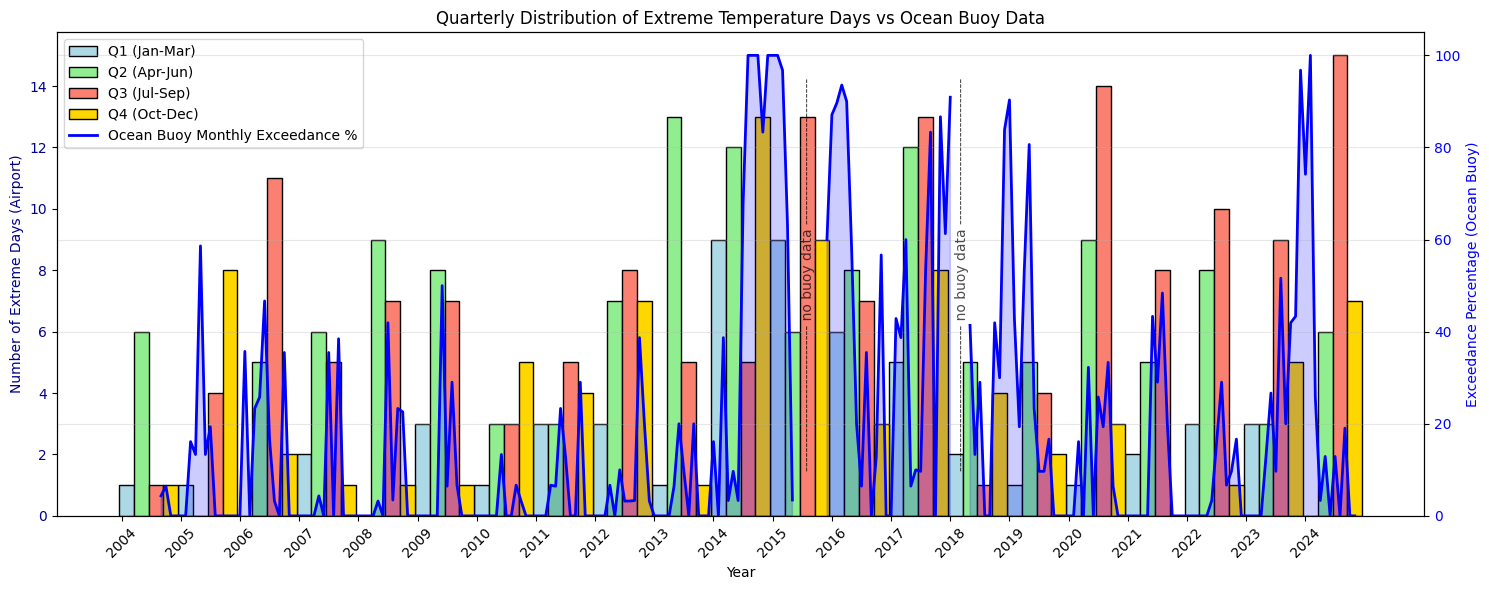

In [33]:
# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(15, 6))
ax2 = ax1.twinx()

# Plot quarterly bars on first y-axis
bar_width = 0.25  # Increased width so bars touch
quarters = ['Q1', 'Q2', 'Q3', 'Q4']
quarter_labels = {'Q1': 'Jan-Mar', 'Q2': 'Apr-Jun', 'Q3': 'Jul-Sep', 'Q4': 'Oct-Dec'}

colors = ['lightblue', 'lightgreen', 'salmon', 'gold']
year_ints = [int(year) for year in years]

# Calculate quarter centers (middle month of each quarter)
quarter_offsets = {
    'Q1': 1/12,  # February (middle of Q1)
    'Q2': 4/12,  # May (middle of Q2)
    'Q3': 7/12,  # August (middle of Q3)
    'Q4': 10/12  # November (middle of Q4)
}

for i, (quarter, color) in enumerate(zip(quarters, colors)):
    mask = df_quarterly['quarter'] == quarter
    x_positions = df_quarterly[mask]['year'] + quarter_offsets[quarter]
    ax1.bar(x_positions, 
            df_quarterly[mask]['count'],
            width=bar_width,
            label=f'{quarter} ({quarter_labels[quarter]})',
            color=color,
            edgecolor='black',
            linewidth=1)

ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Extreme Days (Airport)', color='darkblue')
ax1.tick_params(axis='y', labelcolor='darkblue')

# Plot monthly buoy data
buoy_df['year_fraction'] = buoy_df['date'].dt.year + (buoy_df['date'].dt.month - 1) / 12
ax2.fill_between(buoy_df['year_fraction'], 
                 buoy_df['exceedance_percentage'],
                 color='blue',  #'navy',
                 alpha=0.2) #0.15)  # Very transparent fill
ax2.plot(buoy_df['year_fraction'], 
         buoy_df['exceedance_percentage'],
         color='blue',  #'navy',
         linewidth=2,
         label='Ocean Buoy Monthly Exceedance %')

no_data_str = "-"*30 + " no buoy data " + "-"*30    
y_mid = ax2.get_ylim()[1] / 2  # Get middle of y-axis
ax2.text(2015.6, y_mid, no_data_str, rotation=90, ha='center', va='center', alpha=0.7)
ax2.text(2018.2, y_mid, no_data_str, rotation=90, ha='center', va='center', alpha=0.7)

ax2.set_ylabel('Exceedance Percentage (Ocean Buoy)', color='blue')  #'navy')
ax2.tick_params(axis='y', labelcolor='blue')  #'navy')

# Add legends for both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Quarterly Distribution of Extreme Temperature Days vs Ocean Buoy Data')
plt.grid(True, alpha=0.3)

# Format x-axis
ax1.set_xticks(year_ints)
ax1.set_xticklabels(year_ints, rotation=45)

# Ensure both y-axes start at 0
ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)

plt.tight_layout()
plt.show()